In [ ]:
!pip install google-play-scraper
!pip install nltk sastrawi
!pip install deep-translator
!pip install matplotlib seaborn wordcloud

from google_play_scraper import app, Sort, reviews_all
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from deep_translator import GoogleTranslator
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def scrape_playstore_reviews_multi_country(app_id, jumlah_target=15000):

    try:
        app_info = app(app_id)
        print(f"Aplikasi: {app_info['title']}")
        print(f"Rating: {app_info['score']}")
        print(f"Total review di Play Store: {app_info['reviews']}\n")

        countries = ['id', 'us', 'jp', 'kr', 'sg', 'in', 'ph']
        all_reviews = []

        for country in countries:
            print(f"Mengambil review dari negara: {country}")
            try:
                reviews_country = reviews_all(
                    app_id,
                    sleep_milliseconds=0,
                    lang='id',
                    country=country,
                    sort=Sort.NEWEST
                )
                all_reviews.extend(reviews_country)
                print(f"   Total terkumpul: {len(all_reviews)} reviews")

                if len(all_reviews) >= jumlah_target:
                    print(f"\nTarget {jumlah_target} reviews tercapai!\n")
                    break
            except Exception as e:
                print(f"   Error di {country}: {e}")
                continue

        reviews_data = []
        for review in all_reviews[:jumlah_target]:
            reviews_data.append({
                'username': review['userName'],
                'rating': review['score'],
                'text': review['content'],
                'date': review['at'],
                'thumbsUp': review['thumbsUpCount'],
                'replyContent': review.get('replyContent', None),
                'replyDate': review.get('repliedAt', None)
            })

        df = pd.DataFrame(reviews_data)

        print(f"Total baris: {len(df)}")
        print(f"Rentang tanggal: {df['date'].min()} → {df['date'].max()}")
        print(f"Distribusi Rating:")
        print(df['rating'].value_counts().sort_index())

        return df

    except Exception as e:
        print(f"Error: {e}")
        return None

app_id = 'com.YoStarEN.StellaSora'
df_reviews = scrape_playstore_reviews_multi_country(app_id, jumlah_target=15000)

Aplikasi: Stella Sora
Rating: 3.2916667
Total review di Play Store: 929

Mengambil review dari negara: id
   Total terkumpul: 4911 reviews
Mengambil review dari negara: us
   Total terkumpul: 9822 reviews
Mengambil review dari negara: jp
   Total terkumpul: 14733 reviews
Mengambil review dari negara: kr
   Total terkumpul: 19644 reviews

Target 15000 reviews tercapai!

Total baris: 15000
Rentang tanggal: 2025-10-18 03:38:35 → 2025-12-11 05:55:07
Distribusi Rating:
rating
1    8077
2     649
3     846
4     848
5    4580
Name: count, dtype: int64


In [ ]:
tqdm.pandas()

def translate_to_indonesian(text):
    try:
        return GoogleTranslator(source='auto', target='id').translate(text)
    except:
        return text

print("Proses translasi teks ulasan ke Bahasa Indonesia...")

df_reviews['translated_text'] = df_reviews['text'].progress_apply(translate_to_indonesian)

df_reviews['clean_text'] = df_reviews['translated_text']
print("✅ Translasi selesai dan disimpan ke kolom 'translated_text'")

Proses translasi teks ulasan ke Bahasa Indonesia...


100%|██████████| 15000/15000 [59:06<00:00,  4.23it/s]

✅ Translasi selesai dan disimpan ke kolom 'translated_text'


In [ ]:
filename = 'dataset_stella_sora_original.csv'
df_reviews.to_csv(filename, index=False)
print(f"Dataset original disimpan ke: {filename}")

Dataset original disimpan ke: dataset_stella_sora_original.csv


In [ ]:
df_reviews.head(30)

,username,rating,text,date,thumbsUp,replyContent,replyDate,translated_text,clean_text
0,Pengguna Google,1,Saya sangat suka game ini dalam semua aspek ta...,2025-12-11 05:55:07,0,None,NaT,Saya sangat suka game ini dalam semua aspek ta...,Saya sangat suka game ini dalam semua aspek ta...
1,Pengguna Google,5,Kalian yang ngerjain Stella Sora itu keren ban...,2025-12-11 05:31:48,0,None,NaT,Kalian yang ngerjain Stella Sora itu keren ban...,Kalian yang ngerjain Stella Sora itu keren ban...
2,Pengguna Google,5,Nice game.,2025-12-11 04:57:32,0,None,NaT,Permainan yang bagus.,Permainan yang bagus.
3,Pengguna Google,4,untuk saat ini masih enjoy,2025-12-11 03:50:42,0,None,NaT,untuk saat ini masih enjoy,untuk saat ini masih enjoy
4,Pengguna Google,5,bagus sih game nya gk pelit kyk riview di tikt...,2025-12-11 02:38:58,0,None,NaT,bagus sih game nya gk pelit kyk riview di tikt...,bagus sih game nya gk pelit kyk riview di tikt...
5,Pengguna Google,3,"I can't switch my account, please fix in.",2025-12-11 02:30:25,0,None,NaT,"Saya tidak dapat mengganti akun saya, harap pe...","Saya tidak dapat mengganti akun saya, harap pe..."
6,Pengguna Google,1,"stupid game ,stingy game , I hope the game doe...",2025-12-11 01:30:14,0,None,NaT,"game bodoh, game pelit, semoga gamenya tidak b...","game bodoh, game pelit, semoga gamenya tidak b..."
7,Pengguna Google,2,Perbaiki network nya. masa sinyal bagus gagal ...,2025-12-10 20:53:49,0,None,NaT,Perbaiki network nya. masa sinyal bagus gagal ...,Perbaiki network nya. masa sinyal bagus gagal ...
8,Pengguna Google,5,"Gameplay bagus, animasi bertarung dan efekmya ...",2025-12-10 19:31:49,13,None,NaT,"Gameplay bagus, animasi bertarung dan efekmya ...","Gameplay bagus, animasi bertarung dan efekmya ..."
9,Pengguna Google,4,halo ada bug di chapter story yang terbaru lay...,2025-12-10 16:54:49,0,None,NaT,halo ada bug di chapter story yang terbaru lay...,halo ada bug di chapter story yang terbaru lay...


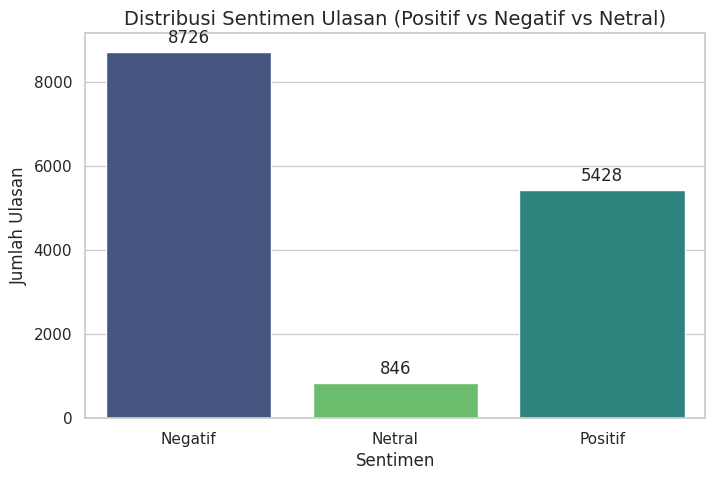

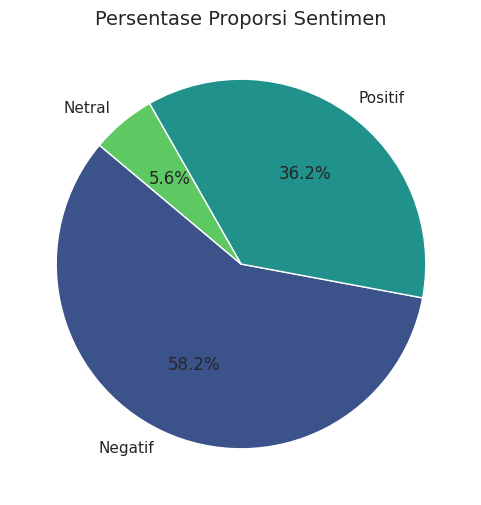

In [ ]:
# Set gaya visualisasi
sns.set(style="whitegrid")

# Tambahkan kolom sentimen berdasarkan rating
def classify_sentiment(rating):
    if rating >= 4:
        return 'Positif'
    elif rating == 3:
        return 'Netral'
    else:
        return 'Negatif'

df_reviews['sentiment'] = df_reviews['rating'].apply(classify_sentiment)

# 1. Visualisasi Distribusi Sentimen (Bar Chart)
plt.figure(figsize=(8, 5))
# Addressing FutureWarning: Passing `palette` without assigning `hue` is deprecated.
# Assign 'sentiment' to `hue` and set `legend=False` for the same effect.
ax = sns.countplot(x='sentiment', data=df_reviews, hue='sentiment', palette='viridis', order=['Negatif', 'Netral', 'Positif'], legend=False)

# Menambahkan label angka di atas batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Distribusi Sentimen Ulasan (Positif vs Negatif vs Netral)', fontsize=14)
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.show()

# 2. Visualisasi Persentase (Pie Chart)
plt.figure(figsize=(6, 6))
sentiment_counts = df_reviews['sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', 3))
plt.title('Persentase Proporsi Sentimen', fontsize=14)
plt.show()

Generating Word Cloud for Positive Reviews...


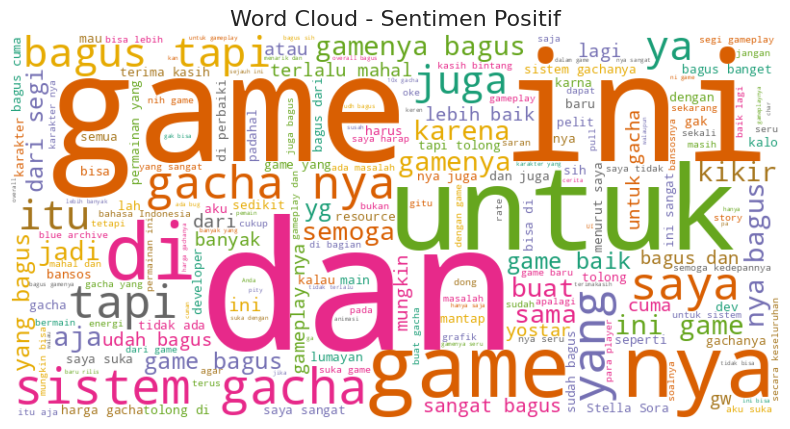

Generating Word Cloud for Negative Reviews...


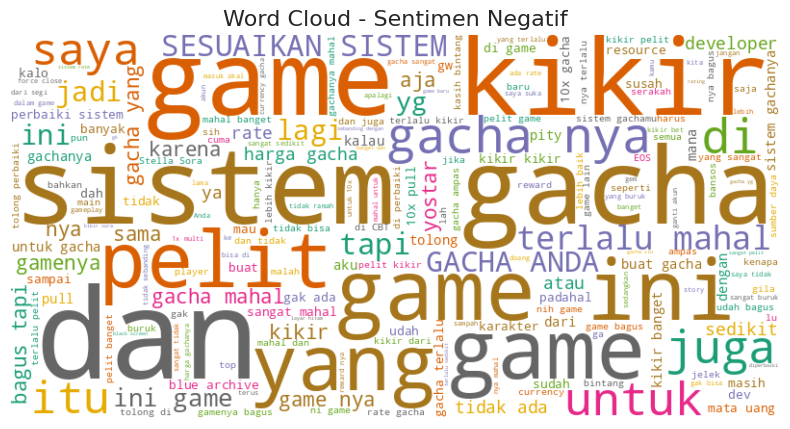

In [ ]:
# Fungsi untuk membuat Word Cloud
def generate_wordcloud(text_data, title):
    all_text = ' '.join(text_data.astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Dark2').generate(all_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Word Cloud untuk Sentimen Positif
print("Generating Word Cloud for Positive Reviews...")
df_positif = df_reviews[df_reviews['sentiment'] == 'Positif']
generate_wordcloud(df_positif['clean_text'], 'Word Cloud - Sentimen Positif')

# Word Cloud untuk Sentimen Negatif
print("Generating Word Cloud for Negative Reviews...")
df_negatif = df_reviews[df_reviews['sentiment'] == 'Negatif']
generate_wordcloud(df_negatif['clean_text'], 'Word Cloud - Sentimen Negatif')

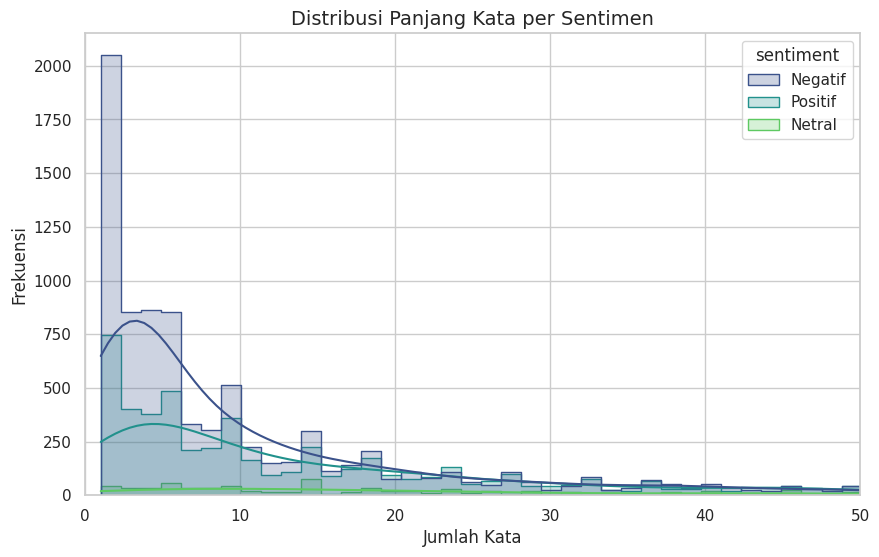

In [ ]:
# Hitung jumlah kata per ulasan
df_reviews['word_count'] = df_reviews['clean_text'].apply(lambda x: len(str(x).split()))

# Plot Histogram Distribusi Jumlah Kata
plt.figure(figsize=(10, 6))
sns.histplot(data=df_reviews, x='word_count', hue='sentiment', kde=True, element="step", palette='viridis')
plt.title('Distribusi Panjang Kata per Sentimen', fontsize=14)
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.xlim(0, 50) # Membatasi tampilan x-axis agar tidak terlalu panjang (bisa disesuaikan)
plt.show()